# 目标检测：口罩佩戴检测  

<br>
<hr>

## 1.实验介绍

### 1.1 实验背景  

今年一场席卷全球的新型冠状病毒给人们带来了沉重的生命财产的损失。  
有效防御这种传染病毒的方法就是积极佩戴口罩。  
我国对此也采取了严肃的措施，在公共场合要求人们必须佩戴口罩。  
在本次实验中，我们要建立一个目标检测的模型，可以识别图中的人是否佩戴了口罩。

### 1.2 实验要求

1）建立深度学习模型，检测出图中的人是否佩戴了口罩，并将其尽可能调整到最佳状态。  
2）学习经典的模型 MTCNN 和 MobileNet 的结构。  
3）学习训练时的方法。  
<br>

### 1.3 实验环境

可以使用基于 Python 的 OpenCV 、PIL 库进行图像相关处理，使用 Numpy 库进行相关数值运算，使用 Pytorch 等深度学习框架训练模型等。
<br>
<br>

### 1.4 注意事项  
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。

### 1.5 参考资料
+ 论文 Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks：https://kpzhang93.github.io/MTCNN_face_detection_alignment/
+ OpenCV：https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html
+ PIL：https://pillow.readthedocs.io/en/stable/
+ Numpy：https://www.numpy.org/
+ Scikit-learn： https://scikit-learn.org/
+ PyTorch：https://pytorch.org/

### 1.6 实验思路

针对目标检测的任务，可以分为两个部分：目标识别和位置检测。  
通常情况下，特征提取需要由特有的特征提取神经网络来完成，如 VGG、MobileNet、ResNet 等，这些特征提取网络往往被称为 Backbone 。而在 BackBone 后面接全连接层(FC)就可以执行分类任务。  
但 FC 对目标的位置识别乏力。经过算法的发展，当前主要以特定的功能网络来代替 FC 的作用，如 Mask-Rcnn、SSD、YOLO 等。  
我们选择充分使用已有的人脸检测的模型，再训练一个识别口罩的模型，从而提高训练的开支、增强模型的准确率。

**常规目标检测：**  

<img src="https://imgbed.momodel.cn/20200914162156.png" width=500px/>



**本次案例：**   


<img src="https://imgbed.momodel.cn/20200918102630.png" width=500px/>

<br>
<br>

## 2.数据集介绍

### 2.1 导入 Python 第三方库（包）

In [1]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader


### 2.2 导入已经写好的 Python 文件

In [2]:
from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition


### 2.3 数据集介绍

数据信息存放在 `/datasets/5f680a696ec9b83bb0037081-momodel/data` 文件夹下。    
该文件夹主要有文件夹 `image`、文件 `train.txt` 、文件夹 `keras_model_data` 和文件夹 `mindspore_model_data`共四部分：
+ **image 文件夹**：图片分成两类，戴口罩的和没有戴口罩的  
+ **train.txt**：  存放的是 image 文件夹下对应图片的标签（keras 版本作业需要用到）  
+ **keras_model_data** 文件夹：存放 keras 框架相关预训练好的模型 （keras 版本作业需要用到）
+ **mindspore_model_data** 文件夹：存放 mindspore 框架相关预训练好的模型（mindspore 版本作业需要用到）

In [3]:
# 数据集路径
data_path = "./datasets/5f680a696ec9b83bb0037081-momodel/data/"


现在我们尝试读取数据集中戴口罩的图片及其名称

以下是训练集中的正样本：

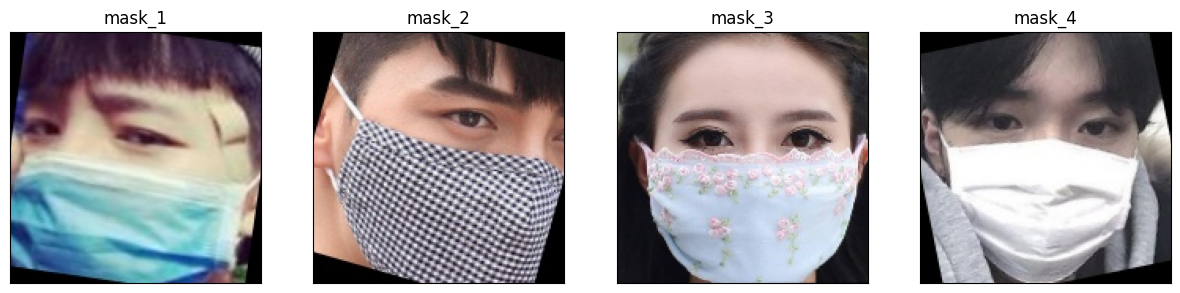

In [4]:
mask_num = 4
fig = plt.figure(figsize=(15, 15))
for i in range(mask_num):
    sub_img = cv2.imread(data_path + "/image/mask/mask_" + str(i + 101) + ".jpg")
    sub_img = cv2.cvtColor(sub_img, cv2.COLOR_RGB2BGR)
    ax = fig.add_subplot(4, 4, (i + 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("mask_" + str(i + 1))
    ax.imshow(sub_img)


以下是训练集中的负样本：

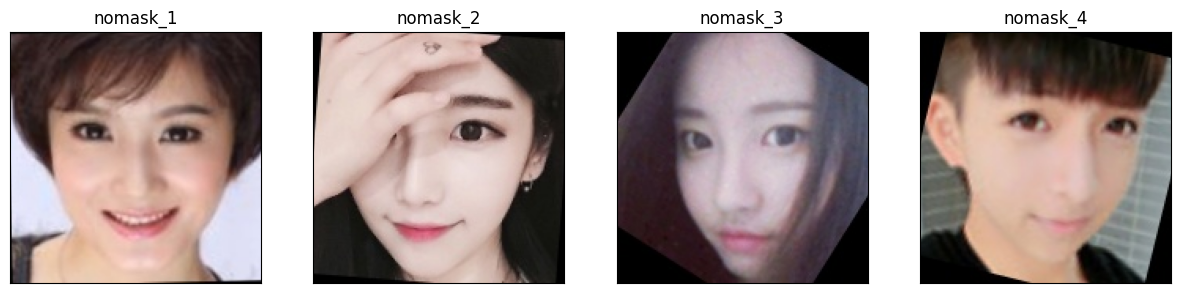

In [5]:
nomask_num = 4
fig1 = plt.figure(figsize=(15, 15))
for i in range(nomask_num):
    sub_img = cv2.imread(data_path + "/image/nomask/nomask_" + str(i + 130) + ".jpg")
    sub_img = cv2.cvtColor(sub_img, cv2.COLOR_RGB2BGR)
    ax = fig1.add_subplot(4, 4, (i + 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("nomask_" + str(i + 1))
    ax.imshow(sub_img)


### 2.4 调整图片尺寸

In [6]:
def letterbox_image(image, size):
    """
    调整图片尺寸
    :param image: 用于训练的图片
    :param size: 需要调整到网络输入的图片尺寸
    :return: 返回经过调整的图片
    """
    new_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    return new_image


查看图片尺寸调整前后的对比

In [7]:
# 使用 PIL.Image 读取图片
read_img = Image.open("test1.jpg")
read_img = np.array(read_img)
print("调整前图片的尺寸:", read_img.shape)
read_img = letterbox_image(image=read_img, size=(50, 50))
read_img = np.array(read_img)
print("调整前图片的尺寸:", read_img.shape)


调整前图片的尺寸: (257, 495, 3)
调整前图片的尺寸: (50, 50, 3)


### 2.5 制作训练时所需的批量数据集

**Pytorch** 读取数据虽然特别灵活，但是还是具有特定的流程的，它的操作顺序为：

+ 创建一个 `Dataset` 对象，该对象如果现有的 `Dataset` 不能够满足需求，我们也可以自定义 `Dataset`，通过继承 `torch.utils.data.Dataset`。在继承的时候，需要 `override` 三个方法。
    + `__init__`： 用来初始化数据集
    + `__getitem__`：给定索引值，返回该索引值对应的数据；它是python built-in方法，其主要作用是能让该类可以像list一样通过索引值对数据进行访问
    + `__len__`：用于len(Dataset)时能够返回大小
+ 创建一个 `DataLoader` 对象
+ 不停的 循环 这个 `DataLoader` 对象

#### 2.5.1 第一步：创建一个 `Dataset` 对象

**torchvision.datasets.ImageFolder** 是一个通用的数据加载器，常见的用法如下：
> dataset=torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>, is_valid_file=None)
    
+ **参数详解**：
    + root：图片存储的根目录，即各类别文件夹所在目录的上一级目录。
    + transform：对图片进行预处理的操作（函数），原始图片作为输入，返回一个转换后的图片。
    + target_transform：对图片类别进行预处理的操作，输入为 target，输出对其的转换。如果不传该参数，即对 target 不做任何转换，返回的顺序索引 0,1, 2…
    + loader：表示数据集加载方式，通常默认加载方式即可。
    + is_valid_file：获取图像文件的路径并检查该文件是否为有效文件的函数(用于检查损坏文件)
    
+ 返回的 dataset 都有以下三种属性：
    + dataset.classes：用一个 list 保存类别名称
    + dataset.class_to_idx：类别对应的索引，与不做任何转换返回的 target 对应
    + dataset.imgs：保存(img-path, class) tuple 的列表

#### 2.5.2 创建一个 `DataLoader` 对象

`DataLoader` 是 `torch` 给你用来包装你的数据的工具，所以你要将( numpy array 或其他) 数据形式装换成 Tensor, 然后再放进这个包装器中。 使用 `DataLoader` 帮助我们对数据进行有效地迭代处理。

> torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False,
 sampler=None,
 batch_sampler=None,
 num_workers=0,
 collate_fn=<function default_collate>,
 pin_memory=False,
 drop_last=False,
 timeout=0,
 worker_init_fn=None)
    
- **常用参数解释**：
    + dataset (Dataset): 是一个 DataSet 对象，表示需要加载的数据集
    + batch_size (int, optional): 每一个 batch 加载多少组样本，即指定 batch_size ，默认是 1 
    + shuffle (bool, optional): 布尔值 True 或者是 False ，表示每一个 epoch 之后是否对样本进行随机打乱，默认是 False

    + sampler (Sampler, optional): 自定义从数据集中抽取样本的策略，如果指定这个参数，那么 shuffle 必须为 False
    + batch_sampler (Sampler, optional): 与 sampler 类似，但是一次只返回一个 batch 的 indices（索引），需要注意的是，一旦指定了这个参数，那么 batch_size,shuffle,sampler,drop_last 就不能再制定了（互斥）

    + num_workers (int, optional): 这个参数决定了有几个进程来处理 data loading 。0 意味着所有的数据都会被 load 进主进程，默认为0
    + collate_fn (callable, optional): 将一个 list 的 sample 组成一个 mini-batch 的函数（这个还不是很懂）
    + pin_memory (bool, optional): 如果设置为True，那么 data loader 将会在返回它们之前，将 tensors 拷贝到 CUDA 中的固定内存（CUDA pinned memory）中

    + drop_last (bool, optional): 如果设置为 True：这个是对最后的未完成的 batch 来说的，比如 batch_size 设置为 64，而一个 epoch只有 100 个样本，那么训练的时候后面的 36 个就被扔掉了，如果为 False（默认），那么会继续正常执行，只是最后的 batch_size 会小一点。
    + timeout (numeric, optional): 如果是正数，表明等待从 worker 进程中收集一个 batch 等待的时间，若超出设定的时间还没有收集到，那就不收集这个内容。这个 numeric 应总是大于等于0，默认为0。

我们采用以上 2 步进行数据处理，代码展示如下:



In [8]:
def processing_data(data_path, height=224, width=224, batch_size=32,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return:
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader


0 
feature: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) 
labels: tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1])


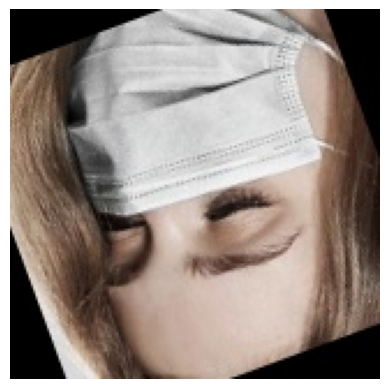

In [9]:
data_path = './datasets/5f680a696ec9b83bb0037081-momodel/data/image'
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=160, width=160, batch_size=32)

def show_tensor_img(img_tensor):
    img = img_tensor[0].data.numpy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 0, 1)
    img = np.array(img)
    plot_image(img)

for index, (x, labels) in enumerate(train_data_loader):
    print(index, "\nfeature:",x[0], "\nlabels:",labels)
    show_tensor_img(x)
    break


## 3. MTCNN：人脸检测

### 3.1  MTCNN 解读

参考文献：《Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks》  
文献与代码地址：https://kpzhang93.github.io/MTCNN_face_detection_alignment/  
  
论文的主要贡献：  
1）**三阶段的级联（cascaded）架构**  
2）**coarse-to-fine 的方式**  
3）**new online hard sample mining 策略**  
4）**同时进行人脸检测和人脸对齐**  
5）**state-of-the-art 性能**  

<img src="https://imgbed.momodel.cn/20200918102724.png"/>

### 3.2 MTCNN 的使用

这里直接使用现有的表现较好的 MTCNN 的三个权重文件，它们已经保存在 `torch_py/MTCNN/weights` 文件夹下，路径如下：


In [10]:
pnet_path = "./torch_py/MTCNN/weights/pnet.npy"
rnet_path = "./torch_py/MTCNN/weights/rnet.npy"
onet_path = "./torch_py/MTCNN/weights/onet.npy"


通过搭建 MTCNN 网络实现人脸检测（搭建模型 py 文件在 torch_py/MTCNN 文件夹） 

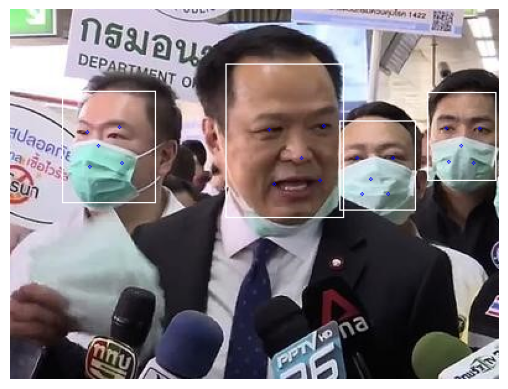

In [11]:
torch.set_num_threads(1)
# 读取测试图片
img = Image.open("test.jpg")
# 加载模型进行识别口罩并绘制方框
recognize = Recognition()
draw = recognize.face_recognize(img)
plot_image(draw)


## 4. 口罩识别



### 4.1 加载预训练模型 MobileNet

In [22]:
# 加载 MobileNet 的预训练模型权
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=160, width=160, batch_size=32)
modify_x, modify_y = torch.ones((32, 3, 160, 160)), torch.ones((32))

epochs = 50
model = MobileNetV1(classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 优化器
print('加载完成...')


加载完成...


### **4.2 手动调整学习率**(可调参）

学习率的手动设置可以使模型训练更加高效。  
这里我们设置当模型在两轮迭代后，准确率没有上升，就调整学习率。

In [22]:
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max',
                                                 factor=0.25,
                                                 patience=15)
# 损失函数
criterion = nn.CrossEntropyLoss()


### 4.3 训练模型

In [30]:
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()

    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)

        # print(pred_y.shape)
        # print(y.shape)

        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss

        loss_list.append(loss)

    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), './results/temp.pth')
print('Finish Training.')


20it [00:03,  5.86it/s]


step:1/40 || Total Loss: 0.4096


20it [00:03,  6.36it/s]


step:2/40 || Total Loss: 0.4986


20it [00:03,  6.32it/s]


step:3/40 || Total Loss: 0.5224


20it [00:03,  6.39it/s]


step:4/40 || Total Loss: 0.4450


20it [00:03,  6.41it/s]


step:5/40 || Total Loss: 0.3160


20it [00:03,  6.29it/s]


step:6/40 || Total Loss: 0.4610


12it [00:01,  6.32it/s]

### 4.4 展示模型训练过程

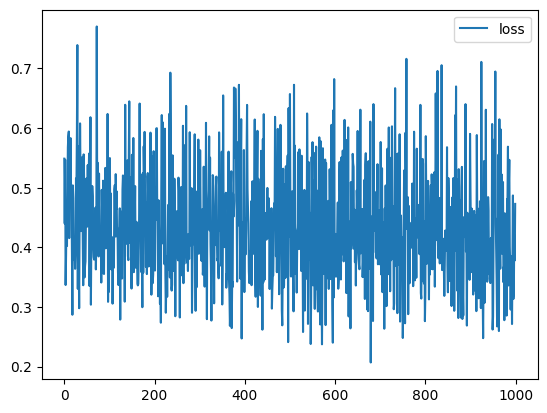

In [28]:
plt.plot([loss.detach().cpu().numpy() for loss in loss_list], label="loss")
plt.legend()
plt.show()

### 4.5 检测图片中人数及戴口罩的人数

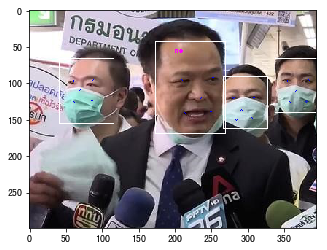

all_num: 4 mask_num 0


In [16]:
img = Image.open("test.jpg")
detector = FaceDetector()
recognize = Recognition(model_path='results/temp.pth')
draw, all_num, mask_nums = recognize.mask_recognize(img)
plt.imshow(draw)
plt.show()
print("all_num:", all_num, "mask_num", mask_nums)


## 5.作业

### 5.1 训练模型

口罩佩戴检测模型训练流程, 包含数据处理、创建模型、训练模型、模型保存、评价模型等。训练模型可以参考第 4.3 部分训练模型代码  
如果对训练出来的模型不满意, 你可以通过调整模型的参数等方法重新训练模型, 直至训练出你满意的模型。  
如果你对自己训练出来的模型非常满意, 则可以提交作业!  

注意：

1. 你可以在我们准好的接口中实现深度学习模型（若使用可以修改函数接口），也可以自己实现深度学习模型。
2. 写好代码后可以在 Py 文件中使用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 进行模型训练。
3. **使用离线训练模型必须保存在 results 文件夹**。    
4. 将自己认为最佳模型保存在 result 文件夹，其余模型备份在项目中其它文件夹，方便您加快测试通过。


===========================================  实现自己的深度学习模型代码答题区域  ===========================================

双击下方区域开始编写  **数据处理**、**创建模型**、**训练模型**、**保存模型**  和  **评估模型**  等部分的代码，请勿在别的位置作答

In [1]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition

from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition
from torch_py.FaceRec import Recognition
from PIL import Image
import cv2

def processing_data(data_path, height=224, width=224, batch_size=32,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader

data_path = './datasets/5f680a696ec9b83bb0037081-momodel/data/image'

# 加载 MobileNet 的预训练模型权
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=160, width=160, batch_size=32)

epochs = 40
model = MobileNetV1(classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 优化器
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max', 
                                                 factor=0.2,
                                                 patience=12)
# 损失函数
criterion = nn.CrossEntropyLoss()  
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()

    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)

        # print(pred_y.shape)
        # print(y.shape)

        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss
            
        loss_list.append(loss)

    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), './results/temp.pth')
print('Finish Training.')

KeyboardInterrupt: 

In [ ]:
# 1.加载数据并进行数据处理


# 2.如果有预训练模型，则加载预训练模型；如果没有则不需要加载

# 3.创建模型和训练模型，训练模型时尽量将模型保存在 results 文件夹

# 4.评估模型，将自己认为最佳模型保存在 result 文件夹，其余模型备份在项目中其它文件夹，方便您加快测试通过。

### 5.2 提交作业

**作业要求及注意事项**：    

1.使用上述学到的方法，训练自己的口罩识别模型，尽可能提高准确度。将训练好的模型保存在 results 文件夹下。             
2.点击左侧栏提交作业后点击【生成文件】则需要勾选与预测 predict() 函数的 cell相关的其它cell ，并将其转化成为 main.py 文件。                       
3.请导入必要的包和第三方库以及该模型所依赖的 py 文件 (包括此文件中曾经导入过的)。             
4.请加载你认为训练最佳的模型，即请按要求填写模型路径。              
5.predict() 函数的输入输出及函数名称请不要改动。


===========================================  **模型预测代码答题区域**  ===========================================  
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [19]:
from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition
from torch_py.FaceRec import Recognition
from PIL import Image
import cv2

# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 dnn.h5 模型，则 model_path = 'results/temp.pth'
model_path = 'results/my_temp.pth'
# ---------------------------------------------------------------------------

def predict(img):
    """
    加载模型和模型预测
    :param img: cv2.imread 图像
    :return: 预测的图片中的总人数、其中佩戴口罩的人数
    """
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 将 cv2.imread 图像转化为 PIL.Image 图像，用来兼容测试输入的 cv2 读取的图像（勿删！！！）
    # cv2.imread 读取图像的类型是 numpy.ndarray
    # PIL.Image.open 读取图像的类型是 PIL.JpegImagePlugin.JpegImageFile
    if isinstance(img, np.ndarray):
        # 转化为 PIL.JpegImagePlugin.JpegImageFile 类型
        img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    recognize = Recognition(model_path)
    img, all_num, mask_num = recognize.mask_recognize(img)
    # -------------------------------------------------------------------------
    return all_num,mask_num


In [20]:
# 输入图片路径和名称
img = cv2.imread("test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
all_num, mask_num = predict(img)
# 打印预测该张图片中总人数以及戴口罩的人数
print(all_num, mask_num)


2 1


In [ ]:
import warnings
import os
import copy # 用于深拷贝模型权重

# 忽视警告
warnings.filterwarnings('ignore')

import cv2 # 尽管导入了，但在主训练流程中未使用
from PIL import Image # 尽管导入了，但在主训练流程中未使用
import numpy as np # 尽管导入了，但在主训练流程中未使用
import matplotlib.pyplot as plt # 用于后续可能的绘图，主训练流程中未使用

from tqdm.auto import tqdm # 进度条

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

# --- 从您的自定义模块导入 ---
# !!! 重要: 确保 torch_py 模块在您的环境中可用 !!!
try:
    from torch_py.Utils import plot_image # 未在主训练流程中使用
    from torch_py.MTCNN.detector import FaceDetector # 未在主训练流程中使用
    from torch_py.MobileNetV1 import MobileNetV1 # 核心模型
    from torch_py.FaceRec import Recognition # 未在主训练流程中使用
except ModuleNotFoundError:
    print("="*50)
    print("错误: 无法导入 torch_py 模块。")
    print("请确保 torch_py 包已正确安装或其路径在 PYTHONPATH 中。")
    print("代码将无法继续执行。")
    print("="*50)
    exit()
# --- 自定义模块导入结束 ---

# ==============================================================================
# 配置参数 (Hyperparameters and Configurations)
# ==============================================================================
# --- 数据相关 ---
DATA_PATH = './datasets/5f680a696ec9b83bb0037081-momodel/data/image' # !!! 修改为您的数据路径 !!!
IMG_HEIGHT = 160 # 图像高度
IMG_WIDTH = 160  # 图像宽度
TEST_SPLIT_RATIO = 0.1 # 验证集划分比例

# --- 训练相关 ---
NUM_CLASSES = 2       # 您的 MobileNetV1 是为2分类任务
BATCH_SIZE = 32       # 批大小
EPOCHS = 100          # 最大训练轮数 (可被早停中断)
LEARNING_RATE = 1e-3  # 初始学习率

# --- 学习率调度器相关 ---
LR_SCHEDULER_PATIENCE = 10 # ReduceLROnPlateau: N轮验证损失未改善则降低学习率
LR_SCHEDULER_FACTOR = 0.2  # ReduceLROnPlateau: 学习率衰减因子

# --- 早停相关 ---
EARLY_STOPPING_PATIENCE = 20 # N轮验证损失未改善则提前停止训练

# --- 模型保存 ---
MODEL_SAVE_DIR = './results' # 模型保存目录
BEST_MODEL_NAME = 'best_mobilenetv1_model1.pth' # 最佳模型文件名

# --- 设备配置 ---
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {DEVICE}")

# ==============================================================================
# 数据处理函数
# ==============================================================================
def processing_data(data_path, height, width, batch_size, test_split):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height: 高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 训练集和验证集的 DataLoader
    """
    # 为训练集和验证集定义不同的转换（通常验证集不做随机增强）
    train_transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(p=0.5), # 50%概率水平翻转
        T.RandomVerticalFlip(p=0.1),   # 10%概率垂直翻转 (如果任务适合)
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05), # 轻微颜色抖动
        T.RandomRotation(degrees=10), # 轻微随机旋转
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # 归一化到[-1, 1]范围 (假设3通道)
        # 如果是单通道图像, 使用: T.Normalize(mean=[0.5], std=[0.5])
        # 如果模型期望ImageNet归一化: T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_transforms = T.Compose([
        T.Resize((height, width)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # 加载完整数据集
    full_dataset = ImageFolder(data_path) # 先不应用transform，后面划分后再分别应用

    # 划分数据集索引
    train_size = int((1 - test_split) * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # 随机划分，确保设置随机种子以复现划分
    torch.manual_seed(42) # 为了可复现的划分
    train_indices, test_indices = torch.utils.data.random_split(range(len(full_dataset)), [train_size, test_size])

    # 为训练集和测试集创建Subset，并分别应用transforms
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.subset)

    train_dataset_raw = torch.utils.data.Subset(full_dataset, train_indices.indices)
    test_dataset_raw = torch.utils.data.Subset(full_dataset, test_indices.indices)

    train_dataset = TransformedSubset(train_dataset_raw, transform=train_transforms)
    test_dataset = TransformedSubset(test_dataset_raw, transform=valid_transforms)


    # 创建 DataLoader
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Data loaded: {len(train_dataset)} training images, {len(test_dataset)} validation images.")
    return train_data_loader, valid_data_loader

# ==============================================================================
# 主训练逻辑
# ==============================================================================
def train_model():
    # --- 准备工作 ---
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # 创建模型保存目录

    # --- 加载数据 ---
    print("Loading and processing data...")
    train_loader, valid_loader = processing_data(
        data_path=DATA_PATH,
        height=IMG_HEIGHT,
        width=IMG_WIDTH,
        batch_size=BATCH_SIZE,
        test_split=TEST_SPLIT_RATIO
    )

    # --- 初始化模型、优化器、损失函数、学习率调度器 ---
    print("Initializing model, optimizer, etc.")
    model = MobileNetV1(classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min', # 监控验证损失，目标是最小化
        factor=LR_SCHEDULER_FACTOR,
        patience=LR_SCHEDULER_PATIENCE,
        verbose=True # 当学习率改变时打印信息
    )

    # --- 训练状态变量 ---
    best_val_loss = float('inf')
    epochs_no_improve = 0 # 用于早停计数
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

    print(f"Starting training for {EPOCHS} epochs...")
    # --- 训练循环 ---
    for epoch in range(EPOCHS):
        # ** 训练阶段 **
        model.train() # 设置模型为训练模式
        running_train_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
        for inputs, labels in train_pbar:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad() # 清空梯度
            outputs = model(inputs) # 前向传播
            loss = criterion(outputs, labels) # 计算损失
            loss.backward() # 反向传播
            optimizer.step() # 更新权重

            running_train_loss += loss.item() * inputs.size(0)
            train_pbar.set_postfix(loss=loss.item())
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # ** 验证阶段 **
        model.eval() # 设置模型为评估模式
        running_val_loss = 0.0
        running_val_corrects = 0
        
        val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]", unit="batch")
        with torch.no_grad(): # 验证时不需要计算梯度
            for inputs, labels in val_pbar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1) # 获取预测类别

                running_val_loss += loss.item() * inputs.size(0)
                running_val_corrects += torch.sum(preds == labels.data)
                val_pbar.set_postfix(loss=loss.item())

        epoch_val_loss = running_val_loss / len(valid_loader.dataset)
        epoch_val_acc = running_val_corrects.double() / len(valid_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item()) # .item() 转换为Python标量

        print(f"\nEpoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {epoch_val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.1e}")

        # --- 学习率调度 ---
        scheduler.step(epoch_val_loss)

        # --- 保存最佳模型 ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME))
            print(f"Epoch {epoch+1}: New best model saved with Val Loss: {best_val_loss:.4f}")
            epochs_no_improve = 0 # 重置早停计数器
        else:
            epochs_no_improve += 1

        # --- 早停检查 ---
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {EARLY_STOPPING_PATIENCE} epochs "
                  f"with no improvement on validation loss.")
            break
            
    print("\nFinished Training.")
    print(f"Best validation loss achieved: {best_val_loss:.4f}")
    print(f"Best model saved at: {os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)}")
    
    # 可选：绘制训练历史
    plot_training_history(history)


# ==============================================================================
# 辅助函数：绘制训练历史 (可选)
# ==============================================================================
def plot_training_history(history):
    if not history['train_loss']: # 如果没有历史记录 (例如0个epoch)
        print("No training history to plot.")
        return

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # 损失曲线
    axs[0].plot(history['train_loss'], label='Train Loss')
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # 准确率曲线
    axs[1].plot(history['val_acc'], label='Validation Accuracy', color='green')
    axs[1].set_title('Validation Accuracy Over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # 学习率曲线
    axs[2].plot(history['lr'], label='Learning Rate', color='red')
    axs[2].set_title('Learning Rate Over Epochs')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Learning Rate')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plot_save_path = os.path.join(MODEL_SAVE_DIR, 'training_history.png')
    plt.savefig(plot_save_path)
    print(f"Training history plot saved to {plot_save_path}")
    plt.show() # 如果在Jupyter Notebook等环境中，可以直接显示

# ==============================================================================
# 程序入口
# ==============================================================================
if __name__ == '__main__':
    train_model()

Using device: cpu
Loading and processing data...
Data loaded: 636 training images, 71 validation images.
Initializing model, optimizer, etc.
Starting training for 100 epochs...




Epoch 1/100 | Train Loss: 0.6296 | Val Loss: 0.6510 | Val Acc: 0.5775 | LR: 1.0e-03
Epoch 1: New best model saved with Val Loss: 0.6510




Epoch 2/100 | Train Loss: 0.5747 | Val Loss: 0.5821 | Val Acc: 0.7042 | LR: 1.0e-03
Epoch 2: New best model saved with Val Loss: 0.5821




Epoch 3/100 | Train Loss: 0.5399 | Val Loss: 0.5164 | Val Acc: 0.7183 | LR: 1.0e-03
Epoch 3: New best model saved with Val Loss: 0.5164




Epoch 4/100 | Train Loss: 0.5261 | Val Loss: 0.5065 | Val Acc: 0.7465 | LR: 1.0e-03
Epoch 4: New best model saved with Val Loss: 0.5065




Epoch 5/100 | Train Loss: 0.5206 | Val Loss: 0.4929 | Val Acc: 0.7606 | LR: 1.0e-03
Epoch 5: New best model saved with Val Loss: 0.4929




Epoch 6/100 | Train Loss: 0.5195 | Val Loss: 0.5504 | Val Acc: 0.7606 | LR: 1.0e-03




Epoch 7/100 | Train Loss: 0.5273 | Val Loss: 0.5185 | Val Acc: 0.7465 | LR: 1.0e-03




Epoch 8/100 | Train Loss: 0.5076 | Val Loss: 0.4841 | Val Acc: 0.7465 | LR: 1.0e-03
Epoch 8: New best model saved with Val Loss: 0.4841




Epoch 9/100 | Train Loss: 0.5145 | Val Loss: 0.5300 | Val Acc: 0.7324 | LR: 1.0e-03




Epoch 10/100 | Train Loss: 0.5064 | Val Loss: 0.4990 | Val Acc: 0.7465 | LR: 1.0e-03




Epoch 11/100 | Train Loss: 0.5141 | Val Loss: 0.4848 | Val Acc: 0.7606 | LR: 1.0e-03




Epoch 12/100 | Train Loss: 0.4963 | Val Loss: 0.5544 | Val Acc: 0.7324 | LR: 1.0e-03


In [21]:
%matplotlib inline
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition

from torch_py.Utils import plot_image
from torch_py.MTCNN.detector import FaceDetector
from torch_py.MobileNetV1 import MobileNetV1
from torch_py.FaceRec import Recognition
from torch_py.FaceRec import Recognition
from PIL import Image
import cv2

def processing_data(data_path, height=224, width=224, batch_size=32,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader

data_path = './datasets/5f680a696ec9b83bb0037081-momodel/data/image'

# 加载 MobileNet 的预训练模型权
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=160, width=160, batch_size=32)

epochs = 40
model = MobileNetV1(classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 优化器
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max', 
                                                 factor=0.2,
                                                 patience=12)
# 损失函数
criterion = nn.CrossEntropyLoss()  
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()

    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)

        # print(pred_y.shape)
        # print(y.shape)

        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss
            
        loss_list.append(loss)

    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), './results/my_temp1.pth')
print('Finish Training.')

20it [00:03,  6.21it/s]


step:1/40 || Total Loss: 0.6117


20it [00:03,  5.32it/s]


step:2/40 || Total Loss: 0.6002


20it [00:03,  6.30it/s]


step:3/40 || Total Loss: 0.4619


20it [00:03,  6.05it/s]


step:4/40 || Total Loss: 0.5619


20it [00:03,  6.43it/s]


step:5/40 || Total Loss: 0.4345


20it [00:03,  6.19it/s]


step:6/40 || Total Loss: 0.3804


20it [00:03,  5.26it/s]


step:7/40 || Total Loss: 0.4887


20it [00:03,  5.79it/s]


step:8/40 || Total Loss: 0.5646


20it [00:03,  6.14it/s]


step:9/40 || Total Loss: 0.4305


20it [00:03,  6.12it/s]


step:10/40 || Total Loss: 0.4705


20it [00:03,  6.26it/s]


step:11/40 || Total Loss: 0.4556


20it [00:03,  6.33it/s]


step:12/40 || Total Loss: 0.4418


20it [00:03,  6.39it/s]


step:13/40 || Total Loss: 0.6431


20it [00:03,  6.40it/s]


step:14/40 || Total Loss: 0.4369


20it [00:03,  6.34it/s]


step:15/40 || Total Loss: 0.3944


20it [00:03,  6.39it/s]


step:16/40 || Total Loss: 0.5562


20it [00:03,  6.44it/s]


step:17/40 || Total Loss: 0.3917


20it [00:03,  6.46it/s]


step:18/40 || Total Loss: 0.5411


20it [00:03,  6.45it/s]


step:19/40 || Total Loss: 0.5802


20it [00:03,  6.45it/s]


step:20/40 || Total Loss: 0.3038


20it [00:03,  6.35it/s]


step:21/40 || Total Loss: 0.4246


20it [00:03,  6.38it/s]


step:22/40 || Total Loss: 0.3554


20it [00:03,  6.10it/s]


step:23/40 || Total Loss: 0.4413


20it [00:03,  5.75it/s]


step:24/40 || Total Loss: 0.3736


20it [00:03,  6.06it/s]


step:25/40 || Total Loss: 0.6311


20it [00:03,  6.06it/s]


step:26/40 || Total Loss: 0.5460


20it [00:03,  6.31it/s]


step:27/40 || Total Loss: 0.5349


20it [00:03,  5.64it/s]


step:28/40 || Total Loss: 0.5092


20it [00:03,  6.06it/s]


step:29/40 || Total Loss: 0.4134


20it [00:03,  6.10it/s]


step:30/40 || Total Loss: 0.5494


20it [00:03,  6.24it/s]


step:31/40 || Total Loss: 0.5453


20it [00:03,  6.12it/s]


step:32/40 || Total Loss: 0.3658


20it [00:03,  6.23it/s]


step:33/40 || Total Loss: 0.2868


20it [00:03,  6.22it/s]


step:34/40 || Total Loss: 0.5611


20it [00:03,  6.22it/s]


step:35/40 || Total Loss: 0.5171


20it [00:03,  5.81it/s]


step:36/40 || Total Loss: 0.7077


20it [00:03,  6.14it/s]


step:37/40 || Total Loss: 0.5076


20it [00:03,  6.19it/s]


step:38/40 || Total Loss: 0.4257


20it [00:03,  6.24it/s]


step:39/40 || Total Loss: 0.6135


20it [00:03,  6.00it/s]

step:40/40 || Total Loss: 0.3033
Finish Training.
